## Human Activity Recognition using Convolution networks and LTSMs

### Importing Libraries & Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
import keras
import pydot

tf.random.set_seed(42)

2023-07-18 12:53:17.330115: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 12:53:17.465729: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-18 12:53:17.465780: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-18 12:53:17.493336: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-18 12:53:19.766060: W tensorflow/stream_executor/platform/de

The MHEALTH (Mobile HEALTH) dataset comprises body motion and vital signs recordings for ten volunteers of diverse profile while performing several physical activities. Sensors placed on the subject's chest, right wrist and left ankle are used to measure the motion experienced by diverse body parts, namely, acceleration, rate of turn and magnetic field orientation. The sensor positioned on the chest also provides 2-lead ECG measurements, which can be potentially used for basic heart monitoring, checking for various arrhythmias or looking at the effects of exercise on the ECG.

In [2]:
df_health = pd.read_csv('mhealth_raw_data.csv')
print(df_health.shape)
print(df_health.head())

(1215745, 14)
      alx     aly      alz       glx      gly      glz     arx     ary  \
0  2.1849 -9.6967  0.63077  0.103900 -0.84053 -0.68762 -8.6499 -4.5781   
1  2.3876 -9.5080  0.68389  0.085343 -0.83865 -0.68369 -8.6275 -4.3198   
2  2.4086 -9.5674  0.68113  0.085343 -0.83865 -0.68369 -8.5055 -4.2772   
3  2.1814 -9.4301  0.55031  0.085343 -0.83865 -0.68369 -8.6279 -4.3163   
4  2.4173 -9.3889  0.71098  0.085343 -0.83865 -0.68369 -8.7008 -4.1459   

        arz      grx     gry       grz  Activity   subject  
0  0.187760 -0.44902 -1.0103  0.034483         0  subject1  
1  0.023595 -0.44902 -1.0103  0.034483         0  subject1  
2  0.275720 -0.44902 -1.0103  0.034483         0  subject1  
3  0.367520 -0.45686 -1.0082  0.025862         0  subject1  
4  0.407290 -0.45686 -1.0082  0.025862         0  subject1  


<AxesSubplot: >

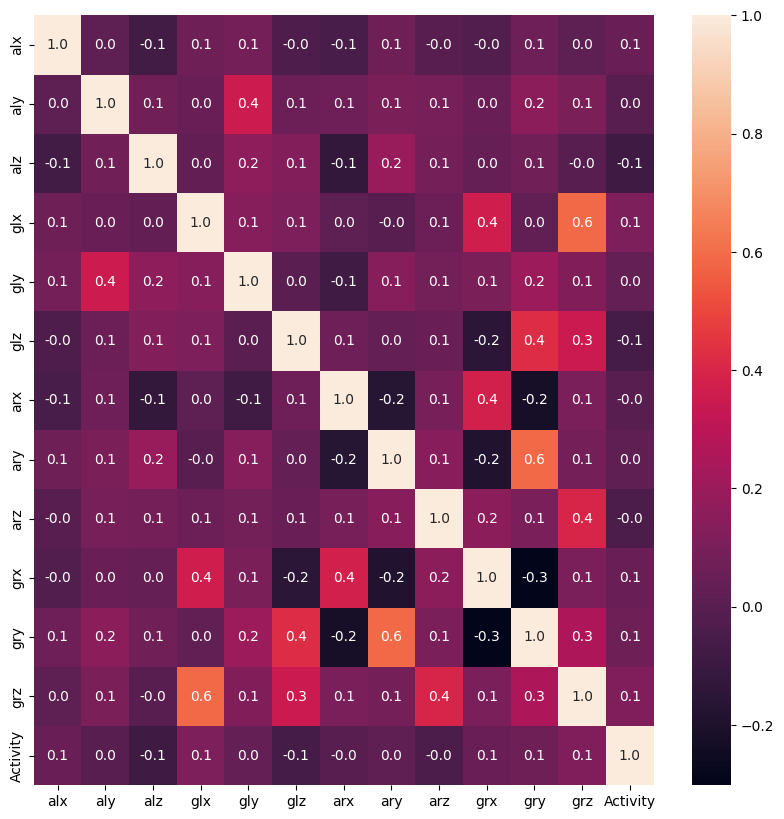

In [3]:
# Plotting the correlation matrix
corr = df_health.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, fmt='.1f')

We can clearly see that the activity label is evenly spread out among its features thus we can include the features without any bias on a particular one.

### Data Cleaning 

In [4]:
# How balanced is our dataset
df_health['Activity'].value_counts()

0     872550
1      30720
2      30720
3      30720
4      30720
5      30720
9      30720
10     30720
11     30720
7      29441
8      29337
6      28315
12     10342
Name: Activity, dtype: int64

In [5]:
# Downsample majority class so as to obtain a balanced dataset
from sklearn.utils import resample
 
df_health_majority = df_health[df_health['Activity'] == 0]
df_health_minorities = df_health[df_health['Activity'] != 0]


df_health_majority_downsampled = resample(df_health_majority, n_samples=30000, random_state=42)
df_health = pd.concat([df_health_majority_downsampled, df_health_minorities])
print('This is the number of samples for each label in our resampled dataset :')
print(df_health['Activity'].value_counts())

This is the number of samples for each label in our resampled dataset :
1     30720
2     30720
3     30720
4     30720
5     30720
9     30720
10    30720
11    30720
0     30000
7     29441
8     29337
6     28315
12    10342
Name: Activity, dtype: int64


In [6]:
# Dropping feature with data outside 98% confidence interval in order to remove outliers
df_health1 = df_health.copy()
for feature in df_health1.columns[:-2]:
  lower_range = np.quantile(df_health[feature],0.01) # quantile basically gives us the percentile distribution of the feature and its entries
  upper_range = np.quantile(df_health[feature],0.99) # from 1 percentile to the 99th
  print(feature,'range:',lower_range,'to',upper_range)

  df_health1 = df_health1.drop(df_health1[(df_health1[feature]>upper_range) | (df_health1[feature]<lower_range)].index, axis=0)
  print('shape',df_health1.shape)

alx range: -11.47312 to 19.233
shape (365733, 14)
aly range: -19.379 to 2.447871999999997
shape (360018, 14)
alz range: -18.95 to 14.19623999999999
shape (356270, 14)
glx range: -0.74212 to 0.80705
shape (349377, 14)
gly range: -1.0694 to 0.96623
shape (342841, 14)
glz range: -1.1061 to 0.8290799999999999
shape (337391, 14)
arx range: -21.492 to 9.097647999999998
shape (332307, 14)
ary range: -18.694000000000003 to 11.948059999999998
shape (326241, 14)
arz range: -10.367 to 11.823119999999996
shape (323674, 14)
grx range: -1.0196 to 0.95686
shape (320188, 14)
gry range: -1.1417 to 0.90965
shape (315352, 14)
grz range: -0.69828 to 1.125
shape (310929, 14)


In [7]:
# Mappping the labels to the various activities
label_map = {
    0: 'Nothing',
    1: 'Standing still',  
    2: 'Sitting and relaxing', 
    3: 'Lying down',  
    4: 'Walking',  
    5: 'Climbing stairs',  
    6: 'Waist bends forward',
    7: 'Frontal elevation of arms', 
    8: 'Knees bending (crouching)', 
    9: 'Cycling', 
    10: 'Jogging', 
    11: 'Running', 
    12: 'Jump front & back' 
}

### Preprocessing Data for Model

In [8]:
# spliting data into training and testing datasets => well be using data form subject 9 & 10 for testing the model later on

print(df_health1.shape)
train = df_health1[(df_health1['subject'] != 'subject10') & (df_health1['subject'] != 'subject9')]
test = df_health1.drop(train.index, axis=0)
print(train.shape,test.shape)

(310929, 14)
(246501, 14) (64428, 14)


In [9]:
# finallizing our train and test datasets with their input and output dfs with activity being our target label
X_train = train.drop(['Activity','subject'],axis=1)
y_train = train['Activity']
X_test = test.drop(['Activity','subject'],axis=1)
y_test = test['Activity']
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(246501, 12) (246501,) (64428, 12) (64428,)


In [10]:
from scipy import stats

#function to create time series datset for sequence modeling
def create_dataset(X, y, time_steps, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        x = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(x)
        ys.append(stats.mode(labels)[0][0]) #the mode of the labels represents the most frequently occurring label within the sequence
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [11]:
# Creating time series dataset with with a time step of 100 for each sequence and a common step of 50 entries
X_train,y_train = create_dataset(X_train, y_train, 100, step=50)
print(X_train.shape, y_train.shape)
X_test,y_test = create_dataset(X_test, y_test, 100, step=50)
print(X_test.shape, y_test.shape)

/tmp/ipykernel_2145/3011470338.py:10: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ys.append(stats.mode(labels)[0][0]) #the mode of the labels represents the most frequently occurring label within the sequence
(4929, 100, 12) (4929, 1)
(1287, 100, 12) (1287, 1)


# Model building

In [12]:
from tensorflow.keras.models import Model

# Input layer => every sequence has 100 entries with 12 features at each time step
inputs = layers.Input(shape=[100,12] , name = 'inputs')

# First convolutional layer
conv_layer = layers.Conv1D(filters=16, kernel_size=3, padding="same")(inputs)

# Batch normalization to reduce internal covariate shift by normalizing the activations
batch_normal_1 = layers.BatchNormalization()(conv_layer)
drop_layer_1 = layers.Dropout(0.2)(batch_normal_1)

# LSTM layer with 64 units with attention layer
lstm_layer_1 = layers.LSTM(64,return_sequences=True)
query_features = lstm_layer_1(drop_layer_1)
value_features = lstm_layer_1(drop_layer_1)
attention_layer_1 = layers.Attention()([query_features,value_features]) # for calculating attention scores to assign weights to the next LSTM layer

# expanding into two separate branches

# Branch 1: Using the Second LSTM layer with 64 units directly
lstm_layer_2 = layers.LSTM(64)(attention_layer_1)

# Branch 2: Dense layer with 64 units followed by batch normalization and dropout layer on the LSTM layer
dense_layer_1 = layers.Dense(units = 64, activation='relu')(lstm_layer_2)
batch_normal_2 = layers.BatchNormalization()(dense_layer_1)
drop_layer_2 = layers.Dropout(0.2)(batch_normal_2) 


# Merging the two branches
concatenated = layers.concatenate([lstm_layer_2,drop_layer_2]) 

# Another dense layer with 64 units
dense_layer_2 = layers.Dense(units = 64, activation = 'relu')(concatenated)
# using softmax activation to get probablity of each label for multi-class classification
outputs = layers.Dense(units = 13, activation='softmax')(dense_layer_2)

# Create the model
model = Model(inputs=inputs, outputs=outputs)
# Compile the model with adam optimizer and sparse categorical crossentropy loss
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

2023-07-18 12:53:29.567399: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-07-18 12:53:29.567495: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-18 12:53:29.567538: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-adc144b1-5328-4efa-88c2-7117c387534e): /proc/driver/nvidia/version does not exist
2023-07-18 12:53:29.567989: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 100, 12)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 100, 16)      592         ['inputs[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 100, 16)     64          ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 dropout (Dropout)              (None, 100, 16)      0           ['batch_normalization[0][0]']

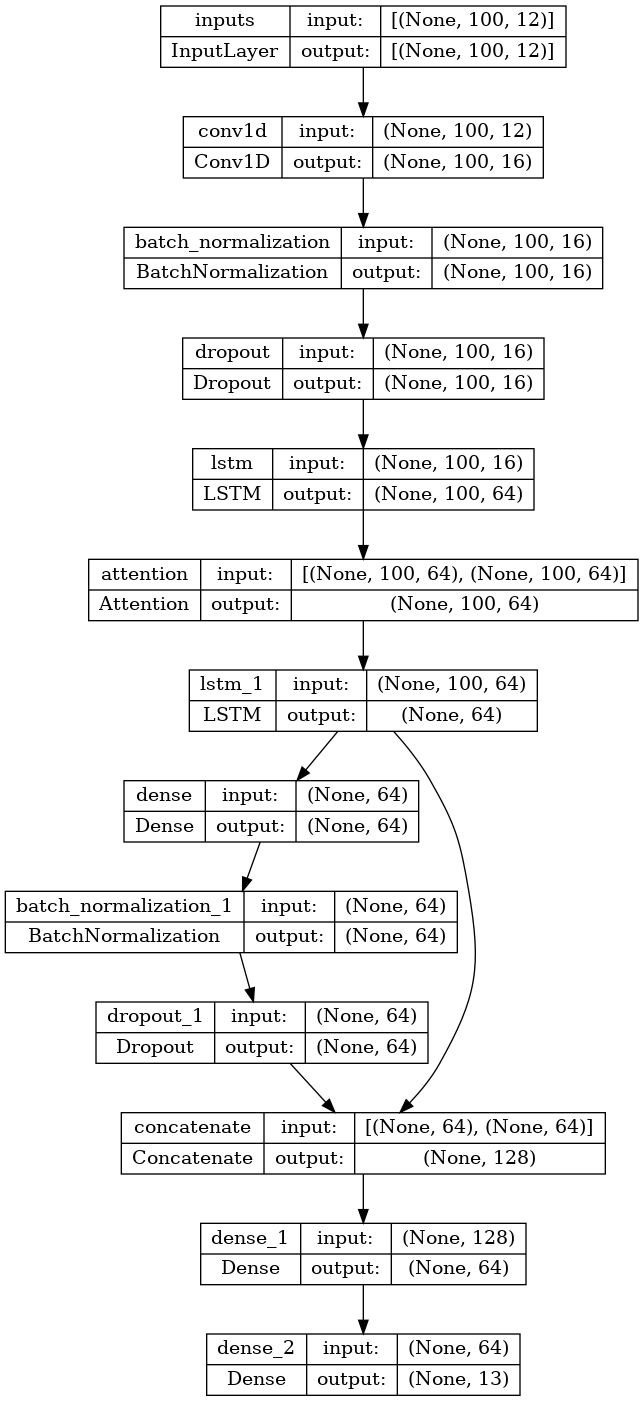

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True, to_file = 'model.png')

In [15]:
callbacks = [keras.callbacks.ModelCheckpoint("mhealth_best.h5", save_best_only=True, monitor="val_loss"),
             keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1)]
model_history = model.fit(X_train,y_train, epochs= 10, validation_data=(X_test,y_test), callbacks=callbacks)

Epoch 1/10
2023-07-18 12:53:34.398642: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "AuthenticAMD" model: "241" frequency: 2649 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 524288 l3_cache_size: 8388608 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
155/155 [==============================] - 36s 202ms/step - loss: 0.8321 - sparse_categorical_accuracy: 0.7432 - val_loss: 1.3025 - val_sparse_categorical_accuracy: 0.5991
Epoch 2/10
155/155 [==============================] - 31s 197ms/step - loss: 0.2648 - sparse_categorical_accuracy: 0.9195 - val_loss: 0.3344 - val_sparse_categorical_accuracy: 0.9161
Epoch 3/10
155/155 

# Model Evaluation

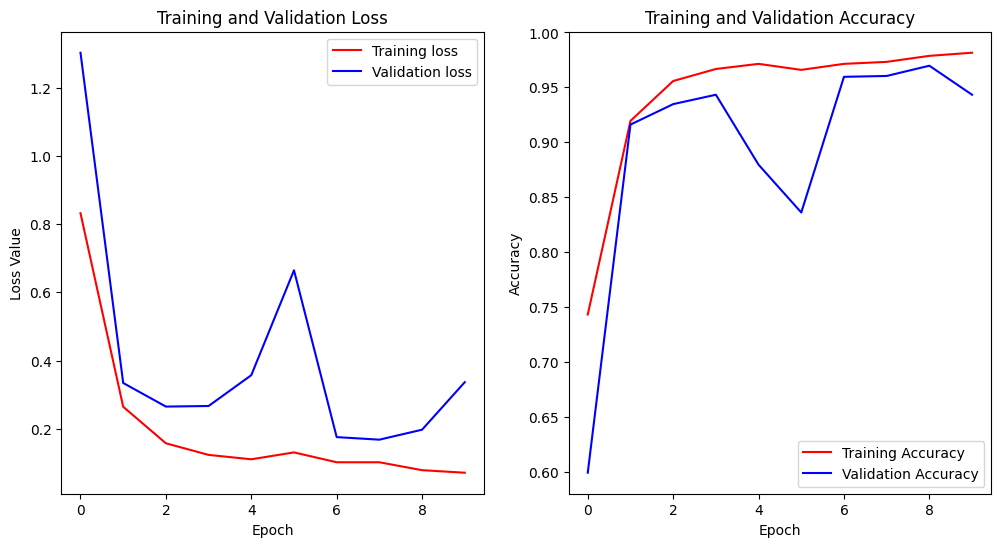

In [19]:
# Evaluating the model and plotting training and validation loss across epochs
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
train_accuracy = model_history.history['sparse_categorical_accuracy']
val_accuracy = model_history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [20]:
# Saving final model for further use and prediction
model = keras.models.load_model('./mhealth_best.h5')

train_loss, train_acc = model.evaluate(X_train,y_train)
test_loss, test_acc = model.evaluate(X_test,y_test)

print("Train accuracy", round(train_acc*100, 2),'%')
print("Train loss", train_loss)
print("Test accuracy", round(test_acc*100, 2),'%')
print("Test loss", test_loss)

2023-07-18 12:59:17.664651: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "AuthenticAMD" model: "241" frequency: 2649 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 524288 l3_cache_size: 8388608 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
41/41 [==============================] - 2s 48ms/step - loss: 0.1683 - sparse_categorical_accuracy: 0.9604
Train accuracy 98.97 %
Train loss 0.047466959804296494
Test accuracy 96.04 %
Test loss 0.1682891547679901


In [21]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis = 1) # we are essentially getting what the model predicted out of the 13 possible labels
pred = pred.reshape(-1,1)
print(pred.shape,y_test.shape)

2023-07-18 12:59:34.026829: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "AuthenticAMD" model: "241" frequency: 2649 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 524288 l3_cache_size: 8388608 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
41/41 [==============================] - 3s 48ms/step
(1287, 1) (1287, 1)


In [22]:
from sklearn.metrics import confusion_matrix, classification_report

# the f1 metrics will correctly evaluate the model performance
print(classification_report(y_test,pred))
print('*'*50)
print(confusion_matrix(y_test,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        92
           1       1.00      0.99      1.00       123
           2       0.87      0.98      0.92       123
           3       0.98      1.00      0.99       122
           4       1.00      0.98      0.99       120
           5       0.97      0.93      0.95        84
           6       0.89      0.98      0.93       106
           7       0.99      0.98      0.99       112
           8       0.94      0.89      0.92       116
           9       0.99      0.86      0.92       121
          10       0.99      0.96      0.97        89
          11       0.98      0.96      0.97        52
          12       0.82      1.00      0.90        27

    accuracy                           0.96      1287
   macro avg       0.96      0.96      0.96      1287
weighted avg       0.96      0.96      0.96      1287

**************************************************
[[ 92   0   0   0   0   0   

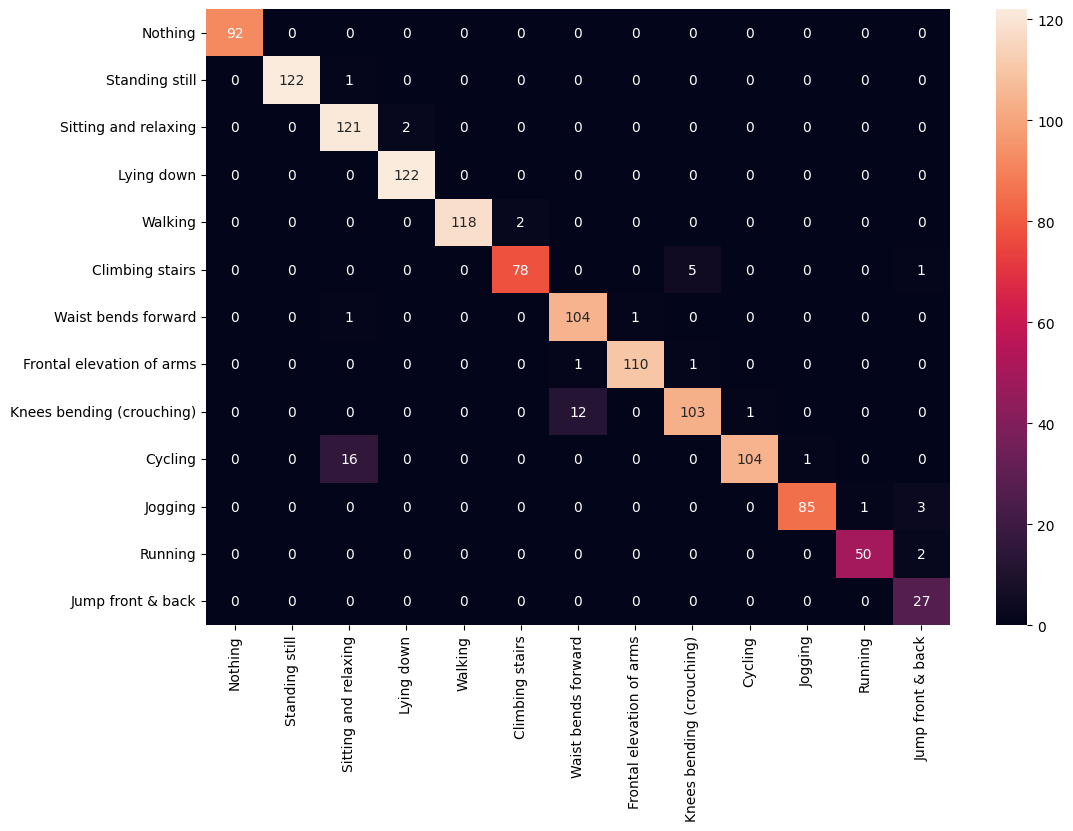

In [23]:
# final heatmap to visualize the confusion matrix
plt.figure(figsize=(12,8))
conf_matrix = confusion_matrix(y_test,pred)
sns.heatmap(conf_matrix, xticklabels= label_map.values(), yticklabels= label_map.values(), annot=True, fmt="d")
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=adc144b1-5328-4efa-88c2-7117c387534e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>